# PyTorch

PyTorch is an open source framework to develop neural-network-based machine learning models: https://pytorch.org.

This guide borrows in part from the [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) and [UvA Deep Learning course](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html).

Topics:
1. Basics
3. Linear regression
4. Linear classification and the Multi-layer perceptron (MLP)
5. Exercise

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set_theme('notebook', style='whitegrid')

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
torch.manual_seed(42) # Setting the seed

print("Using torch", torch.__version__)

Using torch 2.4.1+cu118


## Basics

The primary data structure we need for neural networks is the **tensor**. 

A tensor is similar to a numpy array, and can be of any rank (a rank-1 tensor is a vector, a rank-2 tensor is a matrix). We use here rank and order interchangeably, but please do not confuse it with the rank of a matrix (i.e., the number of linearly independent rows or columns).

In [3]:
x = torch.Tensor(3,4)
print(x)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [4]:
np.zeros((3,4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [5]:
x = torch.rand(3,4) # random values between 0 and 1
print(x)

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])


In [6]:
x = torch.randn(3,4) # random values sampled from a standard normal distribution
print(x)

tensor([[ 2.2082, -0.6380,  0.4617,  0.2674],
        [ 0.5349,  0.8094,  1.1103, -1.6898],
        [-0.9890,  0.9580,  1.3221,  0.8172]])


In [7]:
x.shape

torch.Size([3, 4])

In [8]:
x.view(2,6)

tensor([[ 2.2082, -0.6380,  0.4617,  0.2674,  0.5349,  0.8094],
        [ 1.1103, -1.6898, -0.9890,  0.9580,  1.3221,  0.8172]])

In [9]:
x.sum(axis=0)

tensor([ 1.7541,  1.1293,  2.8941, -0.6053])

### Tensor operations

Other commonly used operations include matrix multiplications, which are essential for neural networks. Quite often, we have an input vector $\mathbf{x}$, which is transformed using a learned weight matrix $\mathbf{W}$. There are multiple ways and functions to perform matrix multiplication, some of which we list below:

* `torch.matmul`: Performs the matrix product over two tensors, where the specific behavior depends on the dimensions. If both inputs are matrices (2-dimensional tensors), it performs the standard matrix product. For higher dimensional inputs, the function supports broadcasting (for details see the [documentation](https://pytorch.org/docs/stable/generated/torch.matmul.html?highlight=matmul#torch.matmul)). Can also be written as `a @ b`, similar to numpy. 
* `torch.mm`: Performs the matrix product over two matrices, but doesn't support broadcasting (see [documentation](https://pytorch.org/docs/stable/generated/torch.mm.html?highlight=torch%20mm#torch.mm))
* `torch.bmm`: Performs the matrix product with a support batch dimension. If the first tensor $T$ is of shape ($b\times n\times m$), and the second tensor $R$ ($b\times m\times p$), the output $O$ is of shape ($b\times n\times p$), and has been calculated by performing $b$ matrix multiplications of the submatrices of $T$ and $R$: $O_i = T_i @ R_i$

Usually, we use `torch.matmul` or `torch.bmm`.

In [10]:
W = torch.arange(4, dtype=torch.float)

In [11]:
W

tensor([0., 1., 2., 3.])

In [12]:
W = W.reshape(4,1)

In [13]:
W

tensor([[0.],
        [1.],
        [2.],
        [3.]])

In [14]:
x

tensor([[ 2.2082, -0.6380,  0.4617,  0.2674],
        [ 0.5349,  0.8094,  1.1103, -1.6898],
        [-0.9890,  0.9580,  1.3221,  0.8172]])

In [15]:
h = torch.matmul(x,W)

In [16]:
h # (3x4)@(4x1)=(3x1); @ is matrix multiplication

tensor([[ 1.0874],
        [-2.0395],
        [ 6.0538]])

### Indexing

Similar to numpy:

In [17]:
x

tensor([[ 2.2082, -0.6380,  0.4617,  0.2674],
        [ 0.5349,  0.8094,  1.1103, -1.6898],
        [-0.9890,  0.9580,  1.3221,  0.8172]])

In [18]:
x[0] # first row

tensor([ 2.2082, -0.6380,  0.4617,  0.2674])

In [19]:
x[:, 1] # second column

tensor([-0.6380,  0.8094,  0.9580])

In [20]:
x[0,1] # value in first row, second column

tensor(-0.6380)

### Backpropagation

PyTorch is useful to express architectures defining **nested functions**, and calculate their **gradients** in order to optimise the **parameters** (or weights) of the network. Submitting an input into a network and operating on it until we reach the output is called a **forward pass** (or forward propagation).

What usually happens is that we define fuctions by expressing multiple layers of operations on the inputs $\textbf{x}$, until we reach an output $\textbf{y}$. We define a **loss function** whose derivative with respect to every possible parameter $\textbf{w}$ will allow us to iteratively optimise their values via **gradient descent**.

**Backpropagation** is the operation of splitting the gradient computation into a series of operations, from the loss to the first layer of the network. It is called backward pass or backward propagation (**backprop** for short).

In [21]:
x = torch.ones((3,))

In [22]:
x

tensor([1., 1., 1.])

In [23]:
# By default, tensors gradients are not calculated
print(x.requires_grad)

False


In [24]:
x.requires_grad_(True)

tensor([1., 1., 1.], requires_grad=True)

In order to get familiar with the concept of a computation graph, we will create one for the following function:

$$y = \frac{1}{|x|}\sum_{i} (x_i)^2,$$

where we use $|x|$ to denote the number of elements in $x$. In other words, we are taking a mean here over the operation within the sum. You could imagine that $x$ are our parameters, and we want to optimise (either maximise or minimise) the output $y$. For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$. 

For our example, we'll use $\mathbf{x}=[0,1,2]$ as our input.

In [25]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [26]:
# Build the computational graph
a = x ** 2
y = a.mean()
print("Y", y)

Y tensor(1.6667, grad_fn=<MeanBackward0>)


In [27]:
y.backward()

`x.grad` will now contain the gradient $\partial y/ \partial \mathcal{x}$, and this gradient indicates how a change in $\mathbf{x}$ will affect output $y$ given the current input $\mathbf{x}=[0,1,2]$:

In [28]:
x.grad

tensor([0.0000, 0.6667, 1.3333])

We can also verify these gradients by hand. We will calculate the gradients using the chain rule, in the same way as PyTorch did it:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$
\frac{\partial a_i}{\partial x_i} = 2\cdot x_i\hspace{1cm}
\frac{\partial y}{\partial a_i} = \frac{1}{3}
$$

Hence, with the input being $\mathbf{x}=[0,1,2]$, our gradients are $\partial y/\partial \mathbf{x}=[0,2/3,4/3]$. The previous code cell should have printed the same result.

### Devices

Testing GPU acceleration. You may see CPU, CUDA, or MPS.
See for more: https://pytorch.org/docs/stable/tensor_attributes.html#torch.device

In [29]:
# Check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

if torch.cuda.is_available():
    x = torch.ones(1, device=device)
    print(x)
    
    # GPU operations have a separate seed we also want to set
    torch.cuda.manual_seed(42)
    
    # Some operations on a GPU are implemented stochastic for efficiency
    # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Print CUDA availability and version
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)


Device: cuda
tensor([1.], device='cuda:0')
CUDA available: True
CUDA version: 11.8


In [30]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In [31]:
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# GPU is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 1.38836s
GPU time: 0.28794s


## Linear regression

In [32]:
# Remember our toy example

mean = [0, 15] # means (centers of mass)
cov = [[5, 0], [120, 100]]  # covariance

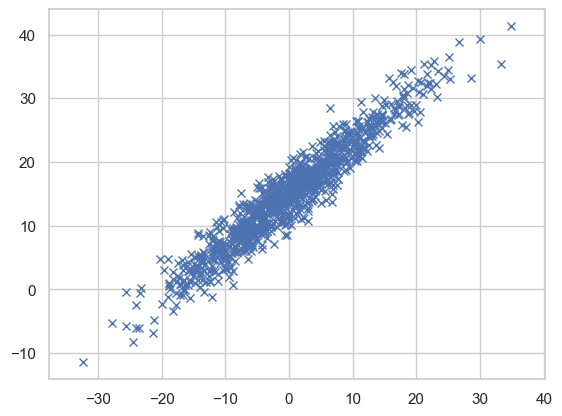

In [33]:
x, y = np.random.multivariate_normal(mean, cov, 1000, check_valid='ignore').T
x = np.float32(x)
y = np.float32(y)
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

Remember that linear regression can be seen as a single-layer network (Figure 3.1.2):

<img src="figures/linear-regression-nn.png" width="600px">

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already.

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers.

In [34]:
import torch.nn as nn
import torch.nn.functional as F

### Defining the model

We use a single `nn.Linear` layer, which by default adds an intercept (bias). See [here for more](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear).

In [35]:
class LinearRegression(nn.Module):
    
    def __init__(self, num_inputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear = nn.Linear(num_inputs, 1)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        y = self.linear(x)
        return y

In [36]:
model = LinearRegression(num_inputs=1)
# Printing a module shows all its submodules
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [37]:
# Printing all named parameters of the network
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear.weight, shape torch.Size([1, 1])
Parameter linear.bias, shape torch.Size([1])


Each layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e., `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules.

### Data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader efficiently loads and stacks the data points into batches during training.

In [38]:
from torch.utils.data import Dataset, DataLoader

The `Dataset` class summarizes the basic functionality of a dataset. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset.

In [39]:
class LinearData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [40]:
x = x.reshape(-1,1) # We need a matrix for data input
data = LinearData(x,y)

In [41]:
data.X.shape, data.y.shape

((1000, 1), (1000,))

The class `DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the `Dataset` class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (for a full list see [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch.
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity. 
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g., large images).
* `pin_memory`: If True, the data loader will copy Tensors into GPU pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

In [42]:
data_loader = DataLoader(data, batch_size=32, shuffle=True)

### Optimization

After defining the model and the dataset, we need to prepare the optimization of the model. 

During training, we will perform the following steps:

1. Get a data batch from the data loader.
2. Obtain the predictions for the batch from the current model.
3. Calculate the loss based on the difference between predictions and labels.
4. Backpropagation: calculate the gradients for every parameter with respect to the loss.
5. Update the parameters of the model in the direction of the gradients.

We have seen steps 1, 2 and 4, we will now look at step 3 and 5.

There are many loss functions already implemented, [see here for a full list](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [43]:
loss_function = torch.nn.MSELoss() 

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. SGD is implemented as `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1. 

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

The optimizer provides two useful functions: `optimizer.step()`, and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. This function is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

### Training

In [45]:
model.to(device) # Push the model to the device

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [46]:
def train_model(model, optimizer, data_loader, loss_function, num_epochs=200):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], we flatten it to [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_function(preds, data_labels)
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero
            # The gradients would not be overwritten, but actually added to the existing ones
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

        # Give some feedback after each 5th pass through the data
        if epoch % 10 == 0:
            print(f"loss: {loss}")

In [47]:
train_model(model, optimizer, data_loader, loss_function)

loss: 59.22520446777344
loss: 5.274620056152344
loss: 9.727392196655273
loss: 2.8164758682250977
loss: 9.691150665283203
loss: 2.0874075889587402
loss: 5.316667556762695
loss: 15.840693473815918
loss: 8.031222343444824
loss: 3.3603062629699707
loss: 24.05017852783203
loss: 6.064345836639404
loss: 2.837052822113037
loss: 6.080883502960205
loss: 1.6052920818328857
loss: 5.146356105804443
loss: 6.135410785675049
loss: 4.162877082824707
loss: 6.072853088378906
loss: 2.9897913932800293


In [48]:
# Saving a model
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear.weight', tensor([[0.8491]], device='cuda:0')), ('linear.bias', tensor([14.8335], device='cuda:0'))])


In [49]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "linear_regression_model.tar")

In [50]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("linear_regression_model.tar")

# Create a new model and load the state
new_model = LinearRegression(num_inputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear.weight', tensor([[0.8491]], device='cuda:0')), ('linear.bias', tensor([14.8335], device='cuda:0'))])

Loaded model
 OrderedDict([('linear.weight', tensor([[0.8491]])), ('linear.bias', tensor([14.8335]))])


C:\Users\casaz\AppData\Local\Temp\ipykernel_17200\3850476713.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("linear_regression_model.tar")


### Evaluation

In [51]:
new_points = np.arange(-40,40,0.5,dtype=np.float32)
x_test = new_points.reshape(new_points.shape[0],1)

In [52]:
model.eval() # Set model to eval mode

with torch.no_grad(): # Deactivate gradients for the following code
    # Determine prediction of model on dev set
    x_test = torch.from_numpy(x_test).to(device)
    preds = model(x_test)
    preds = preds.squeeze(dim=1)

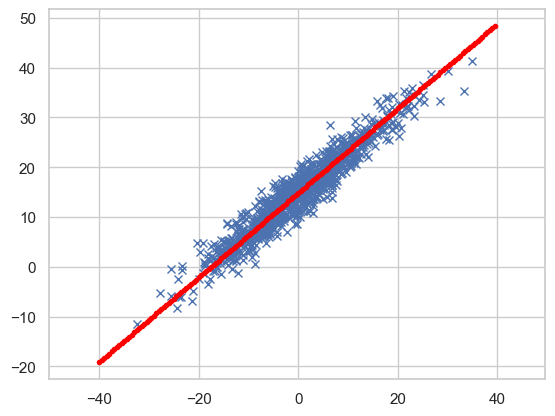

In [53]:
plt.plot(x, y, 'x')
plt.plot(new_points, preds.cpu(), '.', c='red') # Note we swap back the predictions to CPU for plotting
plt.axis('equal')
plt.show()

#### Questions

* Develop the Softmax classifier using a dataset of your choice. See [this module](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) from PyTorch.
* Develop a model to solve this regression task (below). Consider adding at least two layers and a non-linearity to the model.

In [ ]:
# Consider the following dataset
from sklearn.datasets import make_regression # a simpler way to create regression data
x, y = make_regression(n_samples=1000, n_features=1, noise=0.2)
y = np.power(y,2)
plt.plot(x, y, 'x')
plt.show()

In [ ]:
# Your code here


---

## Linear Classification and MLP

In this part, we work on [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), where a MLP classifier is used on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist).

Remember that an MLP is a stack of linear layers separated by non linearities (Figure 5.1.1):

<img src="figures/mlp-nn.png" width="600px">

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

### Data

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") 
    # Where: N is the batch size, C is the number of channels (1 for black and white), 
    # H and W are height and width respectively, so 28x28 pixels
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Model

We use 3 layers: input, hidden, and output. The layers are separated by [ReLU non-linearities](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU):

<img src="figures/ReLU.png" width="600px">

We use [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) as a container for individual modules:

In [ ]:
print(f"Using {device} device")

# Define model
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # Flattens X from [N, C, H, W] to [N, CxHxW]
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1*28*28, 512), # We start with HxW input features, since we have a single channel
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10) # we have 10 target classes as output
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = MLPClassifier().to(device)
print(model)

### Train

We use the cross-entropy loss and SGD as we know from previous classes.

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_function(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function)
print("Done!")

### Test

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

sample_idx = 105
x, y = test_data[sample_idx][0], test_data[sample_idx][1]

img, label = test_data[sample_idx]
plt.title(classes[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    pred_probab = nn.Softmax(dim=1)(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    print('------\nProbabilities (estimated):')
    for i,p in enumerate(list(pred_probab[0].cpu().numpy())):
        with np.printoptions(precision=3, suppress=True):
            print(classes[i],":",format(p, ".2f"))

#### Questions

* Change the architecture of the network (e.g., add more layers, change the non-linearity, the number of parameters, etc.): Can you get better results?
* Change the training procedure (e.g., more or less epochs, smaller or larger batches of data, etc.): Can you get better results?

---

## Exercise

In this exercise, you are required to develop a classfier for the [QMNIST dataset](https://github.com/facebookresearch/qmnist), consisting of handwritten digits. You are entirely free to use any architecture you like. Consider using the [QMNIST torchvision dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.QMNIST.html#torchvision.datasets.QMNIST).

I encourage you to implemnent the [LeNet-5 architecture from this tutorial](https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html). [See here for a primer on Convolutional Neural Networks (CNNs)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

---